# Chord Extraction and Simplification
In this notebook, the chords from the dataset [iRealPro Corpus of Jazz Standards](https://zenodo.org/record/3546040#.Y3dospDMJeD) will be **extraced, arranged** and **simplified**.

## Extract Chords from Dataset
The dataset can be found in the `data` directory. All files are in the **humdrun kern** format. They have a lot of infroamtion, especially important is the follwoing:

```
*M4/4
*A-:
1D-:maj7
=
1E-7
=
1A-:maj7(C:min7)
=
2C:min7(F:min7)
2F7
=

```
Now that time information plays a role, here is a example of what the output of the file (shown above) after prcessing must look like. Observe that we have a **4/4 rythm**. Each "=" is a **barline**. We have to take care of that. If we have a chord like `1E-7` as the only element between two barlines, its played a whole measure. Since we feed the network in $\frac{1}{4}$ steps, this means we have a output of `[E-7, E-7, E-7, E-7]`. Then, observe the barline that contains this two chords:

```
=
2C:min7(F:min7)
2F7
=
```

This means that every chord is played $\frac{2}{4}$ measures, yielding to the output: `[C:min7(F:min7), C:min7(F:min7), F7, F7]`

```
=
4F:min7
4C:min7
4B-:min7
4E-7
=
```

Finally, this means every chord is played $\frac{1}{4}$ measure, giving the sequence `[F:min7, C:min7, B-:min7, E-7]`.

# Todo
- Is there 1/8 chords or faster?
- Check output of new utils function.

In [1]:
import os
import glob
import random

from functions.utils import extract_chords, check_chord, transpose_chord, flatten_chords

### Open all Files
and save it in the variable `all_chords`.

In [2]:
def get_jazz_files(directory):
    jazz_files = []
    for file_path in glob.glob(os.path.join(directory, "*.jazz")):
        jazz_files.append(file_path)
    return jazz_files

jazz_files = get_jazz_files("data")

In [3]:
with open ("data/conferenceofthebirds.jazz", "r") as fh:
    text = fh.read()

extracted = extract_chords(text)
print(extracted)
arranged = flatten_chords(extracted) 
print(arranged)

['2.D:min', '2F', '2.B-', '2E-', '2.D:min', '2F', '2.B-', '2E-']
['D:min', 'D:min', 'D:min', 'F', 'F', 'B-', 'B-', 'B-', 'E-', 'E-', 'D:min', 'D:min', 'D:min', 'F', 'F', 'B-', 'B-', 'B-', 'E-', 'E-']


### Note lenghts
Lets look at the note lenghts. Is there notes shorter than a fourth (1/4)? any other special cases?

In [4]:
durations = {}
for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()
    
    chords = extract_chords(text)
    for chord in chords:
        if len(chord) == 1:
            continue
            
        if chord [1] == ".":
            duration = chord[:2]
        else:
            duration = chord[0]

        if duration not in durations.keys():
            durations[duration] = 1
        else:
            durations[duration] += 1  

durations

{'1': 23967, '2': 29572, '4': 2503, '2.': 3492, '4.': 454, '1.': 102, '8': 30}

We have the follwoing durations:
`{'1': 23967, '2': 29572, '4': 2503, '2.': 3492, '4.': 454, '1.': 102, '8': 30}`

Observe that we have just a bit eight notes (8). They will be converted to fourth, becuse otherwise we have to change the sequcne rythm we feed into the network from 1/4 per sequnce to 1/8 per sequnce - which would double the seunce lenght and then skew the predictions from one chord to the same often times, which is not desired. Since we also have the same problem with the `4.` note since its a sixth (1/6), we will also prune this to a fouth (1/4).

The follwoing rules will now hold:
- Each timestep of the RNN will be 1/4 Bar.
- `8` (eight) be converted to a 1/4
- `4.` (fourth dotted) will be converted to 1/4

### Time signatures

In [5]:
from functions.utils import extract_signature
time_signatures = {}

for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()

    time = extract_signature(text)
    if time == "4/4":
        pass
    elif time == "3/4":
        pass
    else:
        print(file, time)

        
    if time not in time_signatures.keys():
        time_signatures[time] = 1
    else:
        time_signatures[time] += 1

time_signatures

data/bennystune.jazz 6/4
data/conferenceofthebirds.jazz 5/4
data/wildflower.jazz 6/4
data/thebalance.jazz 5/4
data/takefive.jazz 5/4
data/looktotherainbow.jazz 3/2
data/litha.jazz 6/8
data/westcoastblues.jazz 6/4


{'4/4': 1099, '3/4': 79, '6/4': 3, '5/4': 3, '3/2': 1, '6/8': 1}

### Chord Checking
Are all chords in the vocabulary? Are they correctly simplified?

In [6]:
correct_chords = ["C:min", "C:maj", "D:min", "D:maj", "D-:min", "D-:maj",
              "E:min", "E:maj", "E-:min", "E-:maj", "F:min", "F:maj", "G:min", "G:maj",
              "G-:min", "G-:maj", "A:min", "A:maj", "A-:min", "A-:maj", "B:min", "B:maj", "B-:min", "B-:maj"]
print(len(correct_chords))
print(len(all_chords))

for chords in all_chords:
    for chord in chords:
        if chord not in correct_chords:
            print(chord)

24
1186


## Chord Statistics
Now lets look at some stats from the chords - how are they distributed?

### Musical Piece lenghs
How are the lenghts of our pices?

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate lengths of the inner lists
lengths = [len(lst) for lst in all_chords]

# Plot histogram
plt.hist(lengths, bins='auto', edgecolor='black')
plt.title('Distribution of Song Lengths')
plt.xlabel('Length of Song')
plt.ylabel('Frequency')
plt.show()
#plt.savefig('foo.png')

np.mean(lengths)

NameError: name 'all_chords' is not defined

### Chord Counts
Now lets look at some simple Counts from all chords. 

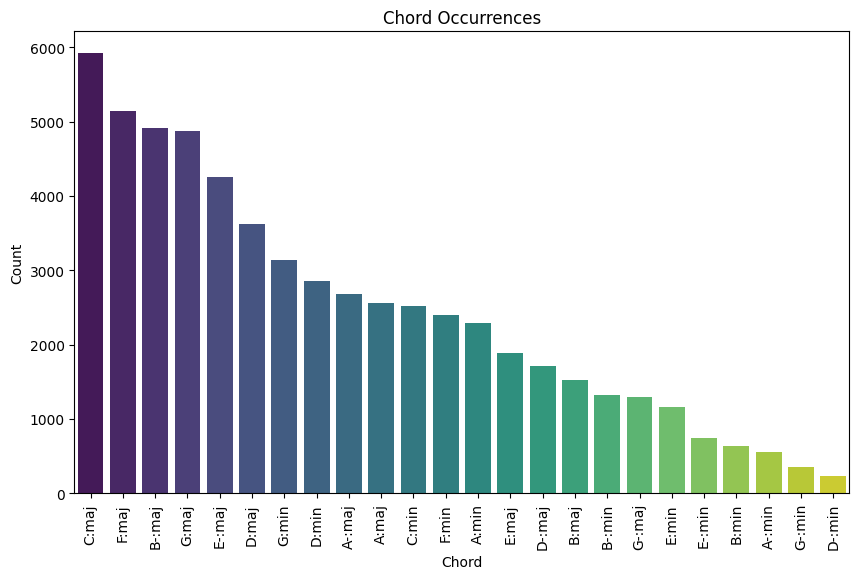

In [8]:


# Assuming your 2D list is named chords
# Flattening the list
flat_list = [item for sublist in all_chords for item in sublist]

# Transforming the list into a DataFrame
df = pd.DataFrame(flat_list, columns=['Chord'])

# Counting the occurrences of each chord
chord_counts = df['Chord'].value_counts()

# Bar plot of chord occurrences
plt.figure(figsize=(10, 6))
sns.barplot(x=chord_counts.index, y=chord_counts.values, palette="viridis")
plt.title('Chord Occurrences')
plt.xlabel('Chord')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.savefig('img/ChordOccurrences.png')
plt.show()

### Chords: Maj vs Min

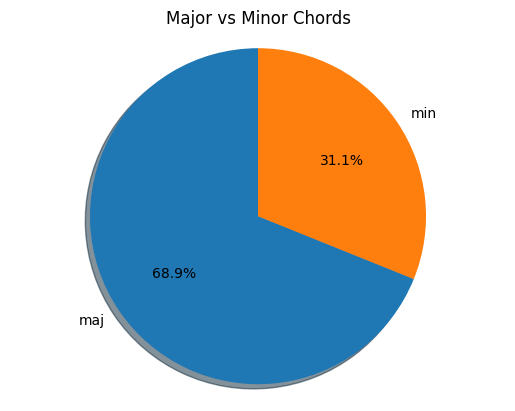

In [9]:
# Counting the occurrences of "maj" and "min"
maj_min_counts = df['Chord'].apply(lambda x: 'maj' if 'maj' in x else 'min').value_counts()

# Creating a pie chart
fig, ax = plt.subplots()
ax.pie(maj_min_counts.values, labels=maj_min_counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Major vs Minor Chords')
plt.show()


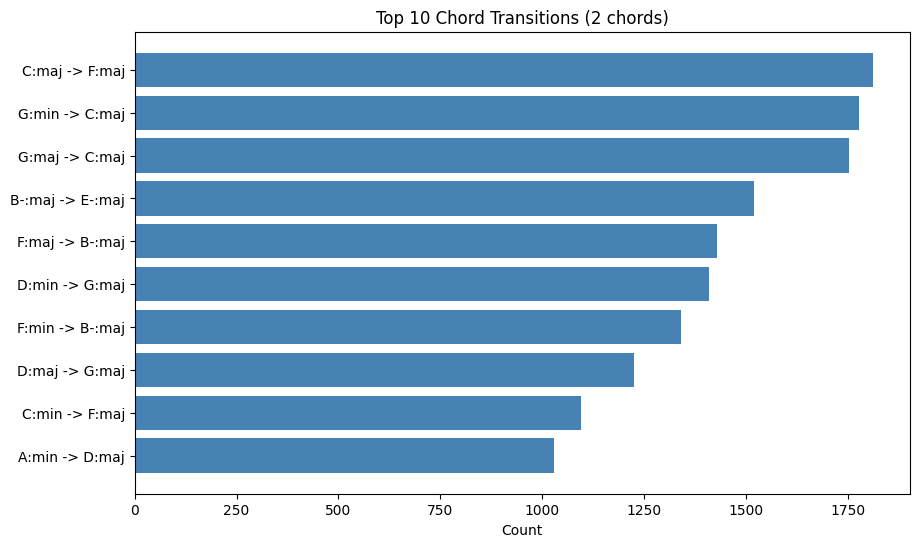

In [10]:
from collections import Counter
from operator import itemgetter

# Initialize a Counter object
transitions = Counter()

# Iterate over all songs (represented as lists of chords)
for song in all_chords:
    # Create pairs of subsequent chords
    pairs = zip(song, song[1:])
    # Increment the count for each pair
    for pair in pairs:
        transitions[pair] += 1

# Extract the 10 most common transitions
top_transitions = transitions.most_common(10)

# Separate pairs and counts for plotting
pairs, counts = zip(*top_transitions)

# Convert pairs of chords to string labels
labels = [f"{pair[0]} -> {pair[1]}" for pair in pairs]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color='steelblue')
plt.xlabel('Count')
plt.title('Top 10 Chord Transitions (2 chords)')
plt.gca().invert_yaxis()  # Reverse the order of labels to have the most common transition on top
plt.savefig("img/top10transitions-2.png")
plt.show()


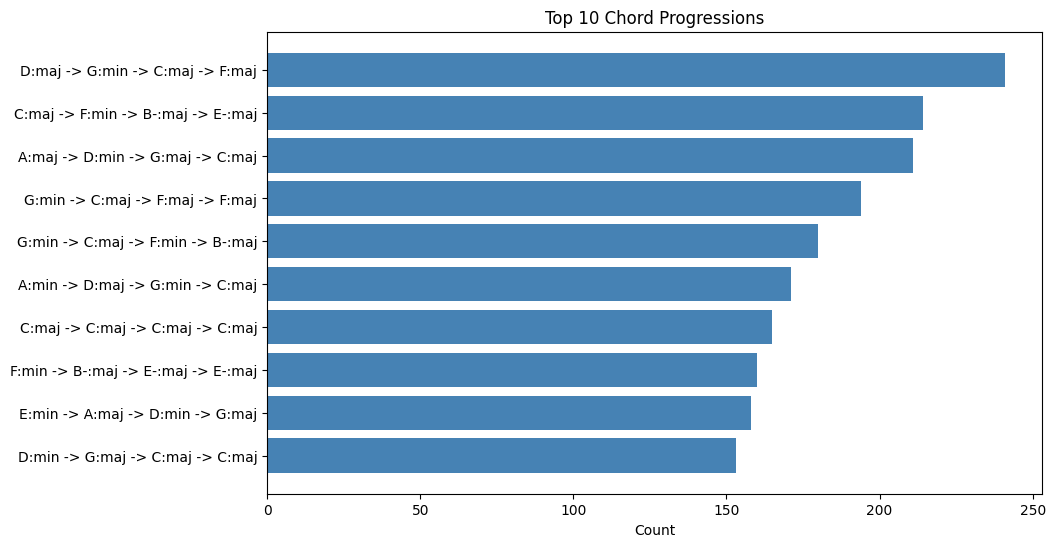

In [11]:
from collections import Counter
from operator import itemgetter

# Initialize a Counter object
transitions = Counter()

# Iterate over all songs (represented as lists of chords)
for song in all_chords:
    # Create 4-tuples of subsequent chords
    tuples = zip(song, song[1:], song[2:], song[3:])
    # Increment the count for each tuple
    for t in tuples:
        transitions[t] += 1

# Extract the 10 most common transitions
top_transitions = transitions.most_common(10)

# Separate tuples and counts for plotting
tuples, counts = zip(*top_transitions)

# Convert tuples of chords to string labels
labels = [' -> '.join(t) for t in tuples]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color='steelblue')
plt.xlabel('Count')
plt.title('Top 10 Chord Progressions')
plt.gca().invert_yaxis()  # Reverse the order of labels to have the most common transition on top
plt.show()

# n gram 

### Chord Transitions Heatmap


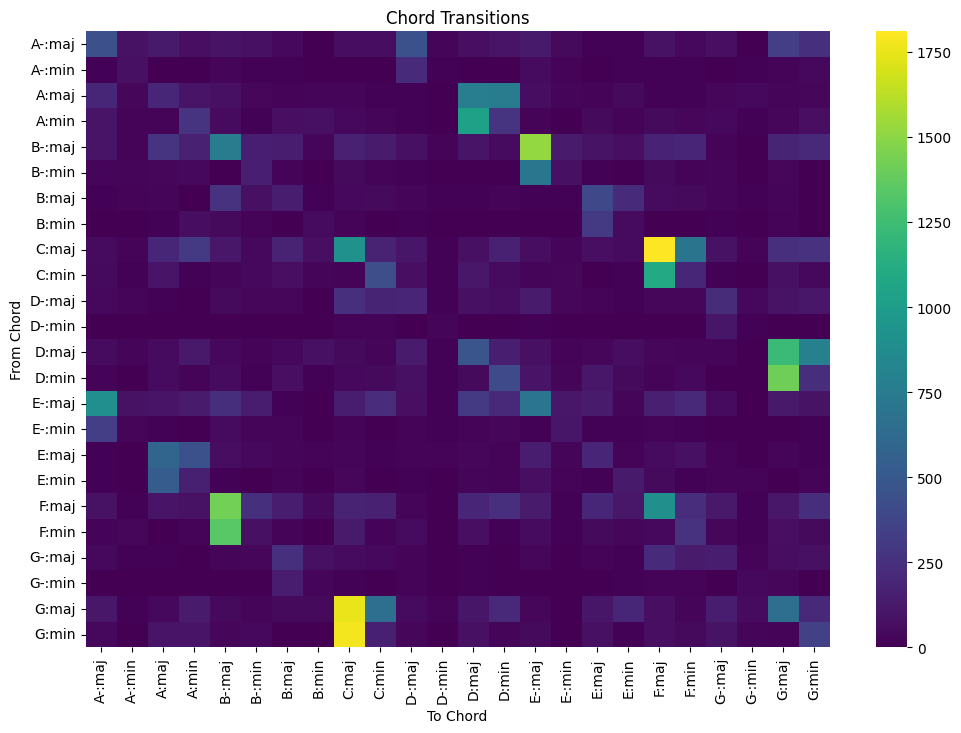

In [12]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Counting the transitions between chords
transitions = Counter()

for sublist in all_chords:
    for i in range(len(sublist) - 1):
        transitions[(sublist[i], sublist[i + 1])] += 1

# Create a DataFrame from the transitions
df_transitions = pd.DataFrame.from_records(list(transitions.items()), columns=['Transitions', 'Count'])

# Unpack Transitions column into separate columns for Chord1 and Chord2
df_transitions[['Chord1', 'Chord2']] = pd.DataFrame(df_transitions['Transitions'].tolist(), index=df_transitions.index)

# Drop the old 'Transitions' column
df_transitions.drop(columns=['Transitions'], inplace=True)

# Pivot the DataFrame to create a matrix for the heatmap
df_pivot = df_transitions.pivot(index='Chord1', columns='Chord2', values='Count')

# Replace NaNs with zeros
df_pivot.fillna(0, inplace=True)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap="viridis")
plt.title('Chord Transitions')
plt.xlabel('To Chord')
plt.ylabel('From Chord')
plt.show()


# Chord Saving
Save chords to file `chords.data` in a json like format.

In [13]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import json

# first, add start and end tokens to the sequnces
def add_tokens(lists):
    # in case already added 
    if lists[0][0] == "<BOS>":
        return lists
    for i in range(len(lists)):            
        # Add "<BOS>" (beginning of sequnce) at the start of the list
        lists[i].insert(0, "<BOS>")
        # Add "<EOS>" (end of sequcne) at the end of the list
        lists[i].append("<EOS>")
    return lists

all_chords = add_tokens(all_chords)

def save_to_json(data, filename="data.json"):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
        
save_to_json(all_chords, "chords.data")

# Encoded Chord saving

In [16]:
from functions.utils import encode_chords

chord_vocab, chord_to_idx, idx_to_chord, padded_sequences, vocab_size = encode_chords(all_chords)

print(padded_sequences)

tensor([[ 1,  8, 15,  ...,  0,  0,  0],
        [ 1,  5, 15,  ...,  0,  0,  0],
        [ 1, 21, 17,  ...,  0,  0,  0],
        ...,
        [ 1, 10, 19,  ...,  0,  0,  0],
        [ 1,  7,  7,  ...,  0,  0,  0],
        [ 1, 21,  3,  ...,  0,  0,  0]])


In [17]:
import csv

def save_tensor_to_csv(tensor, file_name):
    """Saves a tensor to a CSV file."""
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        for row in tensor:
            writer.writerow(row.tolist())

save_tensor_to_csv(padded_sequences, "encoded_chords.csv")